En este script se predice las posiciones siguientes del conjunto de datos PETS-S2L1, 
usando como salida de la red la diferencia de 

In [1]:
import os
import pickle
import numpy 
import pandas as pd
#import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from matplotlib import pyplot
#from numpy import *
from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs, data_file,name):
    # all_ped_data would be a dictionary with mapping from each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId
    # Pedestrians from all datasets are combined
    # Dataset pedestrian indices are stored in dataset_indices
    all_ped_data = {}
    dataset_indices = []
    current_ped = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        #PETS2009-S2L1-mmundo.csv
        #'PETS09-S2L1.txt'
        file_path = os.path.join(directory,name )

        # Cargar datos desde el archivo csv
        # Los datos son una matriz 4x numTrajPoints
        
        
        data = np.genfromtxt(file_path, delimiter=',')
       
        
        # Obtenga el numero de peatones en el conjunto de datos actual
        uni=np.unique(data[:,1])    
        numPeds=np.size(np.unique(data[:,1]))
        print("El numero de peatones en"+ directory+" es "+str(numPeds))

       
        # Para cada peaton en el conjunto de datos
        for ped in range(1, numPeds+1):
            #Son los datos de la persona ped
            traj = data[ data[:, 1] == ped]
            #Esta como (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            
            #Esta como [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Los datos completos son una tupla de todos los datos de peatones y los indices de datos del conjunto de datos.
    complete_data = (all_ped_data, dataset_indices)
    # Almacena los datos completos en el archivo pickle
    f = open(data_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data
    

In [3]:
def load_preprocessed(data_file,seq_length_obs,batch_size):
    
    # cargar los datos
    f = open(data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Obtengo los peatones
    all_ped_data =raw_data[0]
 
    #all_ped_data es el vector {[[],[],[]],...,[[],[],[]]} tantos como pedestrian hayan
    # No usamos dataset_indices por ahora
    # dataset_indices = self.raw_data[1]

    # Construimos data con secuencias(o trayectorias) del largo than seq_length_obs
    data = []
    counter = 0

    # para cada peaton en data
    for ped in all_ped_data:
        
        #ped es un numero entero y va de 1 hasta la cantidad total de pedestrian
        # Extract his trajectory
        traj = all_ped_data[ped]
        
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
               
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:

data_dirs = ['../data1/pets']

datasets = [0]

used_data_dirs = [data_dirs[x] for x in datasets]
      
# Directorio de datos donde reside el archivo pickle preprocesado
data_dir = '../data1'

# Defina la ruta del archivo en el que deben almacenarse los datos.
data_file = os.path.join(data_dir, "datos_limpios_.cpkl")


# Para pets si se usa pixel_pos.csv es el de framerate 7.5
# Para pets si se usa pixel_pos_2.csv es el de framerate 3.75

name ='pixel_pos.csv'
# If the file doesn't exist already or if forcePreProcess is true
#se usa preprocesscsv para los csv y preprocess para el .txt

data = preprocess(used_data_dirs, data_file,name)
datos,numero = load_preprocessed(data_file,12,1)#los ultimos dos valores noimportan

El numero de peatones en../data1/pets es 19


In [5]:
#funcion para preparar los datos para el entrenamiento de la red
def secuencia(seq_length_obs,data):
    tamano=int(len(data))
    
    X,Y = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs
        
        for i in range(0,lon):
            total = traj[i:(i + seq_length_obs ), :]
            X.append(total)
            xx = traj[i:(i + seq_length_obs ), 0]
            yy = traj[i:(i + seq_length_obs ), 1]
            
            #calculamos la x,y con regresion
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            #print(t_var)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/t_var
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/t_var
            y0 = y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            #print("aqui imprimooooo................")
            #print(x_next,y_next)
            #print(traj[i+seq_length_obs, :])
            Y.append(traj[i+seq_length_obs, :]-[x_next,y_next])
    return np.array(X), np.array(Y)

# Visualizacion de Datos

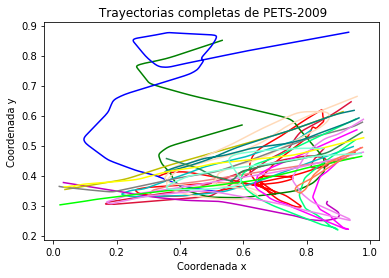

In [6]:
import random
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

for i in range(len(datos)):
    cpu = random.choice(range(17))
    pintar = plt.plot(datos[i][:,0],datos[i][:,1],color=color_names[i])
plt.title(" Trayectorias completas de PETS-2009") 
plt.xlabel("Coordenada x")   
plt.ylabel("Coordenada y") 

#plt.savefig("trayectorias.jpg")
plt.show()  

# Como se divide el conjunto de datos

In [7]:
longitud=len(datos)
ind = range(longitud)

lista = []
for i in range(0,longitud,4):
    lista.append(ind[i:i+4])
#print(lista)

combinacion=[(0,1,2,3,4),(0,1,2,4,3),(0,1,3,4,2),(0,2,3,4,1),(1,2,3,4,0)]

def conjunto_datos(combinacion,lista,datos):
    conjunto_entrenamiento = []
    for i in range(len(combinacion)-1):
       # print(i)
        for j in lista[combinacion[i]]:
        #    print(j)
            conjunto_entrenamiento.append(datos[j])
    conjunto_prueba=[]
    for i in lista[combinacion[4]]:
        #print(i)
        conjunto_prueba.append(datos[i])
    
    return conjunto_entrenamiento,conjunto_prueba

In [8]:
train1,test1 = conjunto_datos(combinacion[0],lista,datos)
train2,test2 = conjunto_datos(combinacion[1],lista,datos)
train3,test3 = conjunto_datos(combinacion[2],lista,datos)
train4,test4 = conjunto_datos(combinacion[3],lista,datos)
train5,test5 = conjunto_datos(combinacion[4],lista,datos)

In [ ]:
length_obs = 8
trainX, trainY = secuencia(length_obs,train3)
#valiX, valiY = secuencia(length_obs,vali1)

In [ ]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],trainX.shape[2]))
#valiX = numpy.reshape(valiX,(valiX.shape[0], valiX.shape[1],valiX.shape[2]))


In [ ]:
data_shape = trainX.shape[1:]
print(data_shape)
import numpy as np
np.shape(trainX)

## Modelo

In [ ]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime



if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(9, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(9, name='lstm2'))
model.add(Dense(2))

In [ ]:
#opt1=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False)
opt = optimizers.RMSprop(lr = 0.006, decay=1e-2)
model.compile( optimizer=opt,loss='logcosh',metrics=['mse'])
history=model.fit(trainX, trainY, epochs=100, batch_size=16, verbose=2 )

In [ ]:
history_dict=history.history
history_dict.keys()

In [ ]:
acc = history.history['mean_squared_error']
#val_acc = history.history['val_mean_squared_error']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

# figure
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig("lstm-regresion2-simplificado.pdf")
plt.show()

# Modelos pets con framerate de 7.5 frames por segundo

In [ ]:
#model.save('lstm-regresion0.h5')# se observa 8 pasos

In [ ]:
#model.save('lstm-regresion1.h5')

In [ ]:
#model.save('lstm-regresion2.h5')

In [ ]:
#model.save('lstm-regresion3.h5')

In [ ]:
#model.save('lstm-regresion4.h5')

# Modelos de pets con framerate de 3.75 frames por segundo

In [ ]:
#model.save('lstm-regresion0-simplificado.h5')

In [ ]:
#model.save('lstm-regresion1-simplificado.h5')

In [ ]:
#model.save('lstm-regresion2-simplificado.h5')

In [ ]:
#model.save('lstm-regresion3-simplificado.h5')

In [ ]:
#model.save('lstm-regresion4-simplificado_aux.h5')

#  Se carga el modelo con el que se va a predecir

In [21]:
modelregre = load_model('lstm-regresion1.h5')

# PREDICCION

In [10]:
def error_desplazamiento_final(predicted_traj, true_traj):
    tam = len(predicted_traj)
    return np.linalg.norm(predicted_traj[tam-1]-true_traj[tam-1])

In [11]:
def error_promedio(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # PARA CADA PUNTO EN LA TRAYECTORIA PREDICHA
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]

        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [12]:
#Funcion para preparar el conjunto de test para predecir una cierta cantidad de pasos 
def secuencia_pred(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
        
        for i in range(0,lon+1):
            a = traj[i:(i+seq_length_obs),:]
            X.append(a)
            b = traj[i:(i+seq_length_obs+seq_length_pred),:]
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [27]:
#Funcion para medir el modelo con el conjunto de test
def sample(test,seq_length_obs,seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    
    todo = []
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
        
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
             
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
        
            next_point = [x_next,y_next]+predict
            
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        total_error += error_promedio(traj_pred , Y_true[i], seq_length_obs)
        total_final += error_desplazamiento_final(traj_pred, Y_true[i])
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    
    ade=[t for o in todo for t in o]
    print('--------Error---------')
    print('ADE')
    print(np.mean(ade))
    print('Error promedio')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    

In [28]:
#Funcion para medir el modelo con el conjunto de test
def sample_en_pixeles(test,seq_length_obs,seq_length_pred):
    
    X,Y_true = secuencia_pred(seq_length_obs,test,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    todo = []
    
    trayectoria = []
    verdadero = []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]

        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
             
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)], next_point), axis = 0)
            traj_pred = np.concatenate((traj_pred, next_point), axis = 0)
            
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
        
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        
        #AQUI SE CALCULA EL ADE
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        
        todo.append(diff)
        
        total_error += error_promedio(traj_pre , traj_tr, seq_length_obs)
        total_final += error_desplazamiento_final(traj_pre , traj_tr)
        
    error_modelo = total_error/len(X)
    error_fde_modelo = total_final/len(X)
    ade = [t for o in todo for t in o]
    
    print('ADE')
    print(np.mean(ade))
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    return trayectoria,verdadero

In [29]:
sample(test1,8,4)

--------Error---------
ADE
0.005004332532252343
Error promedio
0.005004332532252345
FDE
0.007767421829838964


In [30]:
p,v =sample_en_pixeles(test2,8,4)

ADE
2.156057840856447
2.1560578408564472
FDE
3.336630351779393


In [34]:
def secuencia_x_persona(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [37]:
def sample_x_persona(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
            
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
            
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
        #    traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        #traj_pre=np.array(traj_pre)
        #traj_tr=np.array(traj_tr)
        error_prom = error_promedio(traj_pred ,Y_true[i], seq_length_obs)
        FDE = error_desplazamiento_final(traj_pred , Y_true[i])
        
        #AQUI SE CALCULA EL ADE
        diff = Y_true[i][seq_length_obs:]-traj_pred[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pred[seq_length_obs:])
        print("TRAYECTORIA VERDADERA  ")
        print(Y_true[i][seq_length_obs:])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        plt.subplot(1,1,1)
        
        # observada               
        predicha = plt.plot(Y_true[i][:seq_length_obs,0],Y_true[i][:seq_length_obs,1],'*--',color = color_names[19-i])
        # grand truth
        predicha = plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color = color_names[i])
        
        predicha = plt.plot(traj_pred[seq_length_obs-1:,0],
                                  traj_pred[seq_length_obs-1:,1],'-',color=color_names[19-i])
        
        plt.title("Posiciones predichas con LSTM-Variacion Regresion Lineal") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('error ADE')
    print(np.mean(ade))
    #plt.savefig("4posiciones.pdf")
    plt.show()
    

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[0.88662773 0.44374503]
 [0.87658299 0.43833601]
 [0.86652696 0.4326203 ]
 [0.85639656 0.42643813]]
TRAYECTORIA VERDADERA  
[[0.88662109 0.44640625]
 [0.87754297 0.44258403]
 [0.86846979 0.43877014]
 [0.85941172 0.43498646]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.006 
ERROR DE DESPLAZAMIENTO FINAL ES =0.009
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[0.86935991 0.59297486]
 [0.85893184 0.58434026]
 [0.84853435 0.57529618]
 [0.83799917 0.56560815]]
TRAYECTORIA VERDADERA  
[[0.87269753 0.5985809 ]
 [0.86515169 0.59414462]
 [0.85780091 0.58995052]
 [0.85052682 0.58585191]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 0.015 
ERROR DE DESPLAZAMIENTO FINAL ES =0.024
('TRAYECTORIA PREDICHA DEL PEATON ', 3)
[[0.40508596 0.80401531]
 [0.38782472 0.79699337]
 [0.37113325 0.78988319]
 [0.35488548 0.78257552]]
TRAYECTORIA VERDADERA  
[[0.40087982 0.80440174]
 [0.38409583 0.7987217 ]
 [0.3683513  0.79366649]
 [0.3540224  0.78946319]]
EL ERROR

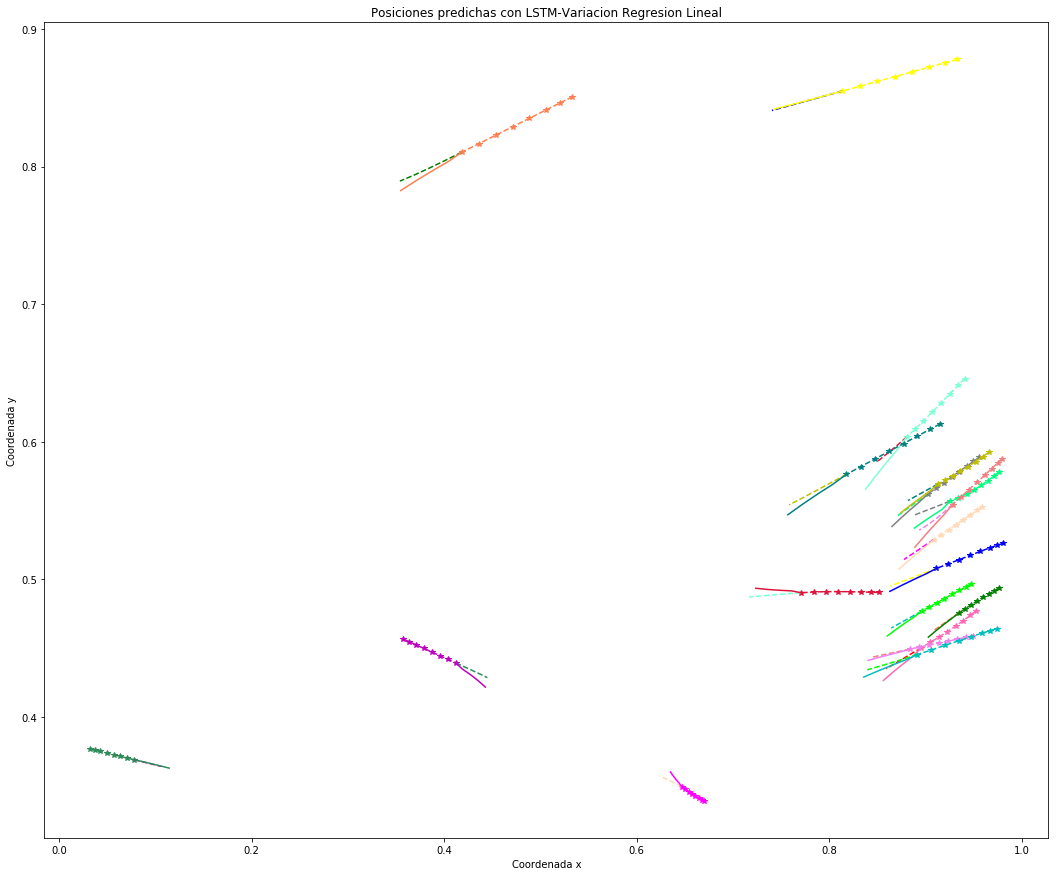

In [38]:
sample_x_persona(datos,8,4)

In [39]:
def sample_x_persona_pixeles(datos, seq_length_obs, seq_length_pred):
    
    X,Y_true = secuencia_x_persona(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15))  
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    todo=[]
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
    
        for j in range(seq_length_pred):
            traj_obsr = numpy.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            predict = modelregre.predict(traj_obsr)
            
            xx = traj_obs[:,0]
            yy = traj_obs[:,1]
            
            t = range(1,len(xx)+1)
            x_mean = np.mean(xx)
            t_mean = np.mean(t)
            t_var = np.var(t)
            xt_cov = np.cov (xx, t)[0][1]
            vx = xt_cov/(t_var)
            x0 = x_mean-(vx*t_mean)
                        
            y_mean = np.mean(yy)
            yt_cov = np.cov (yy, t)[0][1]
            
            vy = yt_cov/(t_var)
            y0= y_mean-(vy*t_mean)
            
            x_next = x0+vx*(len(xx)+1)
            y_next = y0+vy*(len(yy)+1)
            
            next_point = [x_next,y_next]+predict
          
            traj_obs = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
            
        #traj_pre = []
        #traj_tr = []
        #for k in range(len(traj_pred)):
        #    traj_pre.append([768* traj_pred[k,0],576*traj_pred[k,1]])
        #    traj_tr.append([768* Y_true[i][k,0],576*Y_true[i][k,1]])
        
        #traj_pre=np.array(traj_pre)
        #traj_tr=np.array(traj_tr)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
        
        error_prom = error_promedio(traj_pre ,traj_tr, seq_length_obs)
        FDE = error_desplazamiento_final(traj_pre ,traj_tr)
        
        diff = traj_tr[seq_length_obs:]-traj_pre[seq_length_obs:]
        diff = diff**2
        diff = np.sqrt(np.sum(diff,axis=1))
        todo.append(diff)
        
        
    

        print("TRAYECTORIA PREDICHA DEL PEATON ",i+1)
        print(traj_pre[seq_length_obs:])
        print("TRAYECTORIA VERDADERA  ")
        print(traj_tr[seq_length_obs:])
        print("EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = {:.3f} ".format(error_prom))
        print("ERROR DE DESPLAZAMIENTO FINAL ES ={:.3f}".format(FDE))
                         
        cpu = random.choice(range(17))
                         
        plt.subplot(1,1,1)
        
        # observada
        predicha = plt.plot(Y_true[i][:seq_length_obs,0],Y_true[i][:seq_length_obs,1],'*--',color = color_names[cpu])
        # grand truth
        predicha = plt.plot(Y_true[i][seq_length_obs-1:,0],Y_true[i][seq_length_obs-1:,1],'--',color = color_names[cpu])
        # predicho
        predicha = plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[cpu])
        
        plt.title("Las trayectorias de PETS-2009") 
        plt.xlabel('Coordenada x')
        plt.ylabel('Coordenada y')
        
        
        total_error += error_prom
    error_modelo = total_error/len(X)
    ade=[t for o in todo for t in o]
    
    print("EL ERROR PROMEDIO DE TODA LA PREDICCIÓN")
    print(error_modelo)
    print('error ADE')
    print(np.mean(ade))
    #plt.savefig("trayectorias4futureregre.jpg")
    plt.show()
  

('TRAYECTORIA PREDICHA DEL PEATON ', 1)
[[680.93009714 255.59713835]
 [673.2157391  252.48154237]
 [665.49270738 249.18929143]
 [657.71255898 245.62836264]]
TRAYECTORIA VERDADERA  
[[680.925  257.13  ]
 [673.953  254.9284]
 [666.9848 252.7316]
 [660.0282 250.5522]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 3.343 
ERROR DE DESPLAZAMIENTO FINAL ES =5.441
('TRAYECTORIA PREDICHA DEL PEATON ', 2)
[[667.66841246 341.55352171]
 [659.65965035 336.57998697]
 [651.67438416 331.37060078]
 [643.58336223 325.79029696]]
TRAYECTORIA VERDADERA  
[[670.2317 344.7826]
 [664.4365 342.2273]
 [658.7911 339.8115]
 [653.2046 337.4507]]
EL ERROR PROMEDIO DE LA TRAYECTORIA PREDICHA ES = 9.419 
ERROR DE DESPLAZAMIENTO FINAL ES =15.117
('TRAYECTORIA PREDICHA DEL PEATON ', 3)
[[311.1060152  463.1128192 ]
 [297.84938765 459.06818118]
 [285.03033417 454.97271763]
 [272.55205127 450.7635008 ]]
TRAYECTORIA VERDADERA  
[[307.8757 463.3354]
 [294.9856 460.0637]
 [282.8938 457.1519]
 [271.8892 454.7308]]
EL ERRO

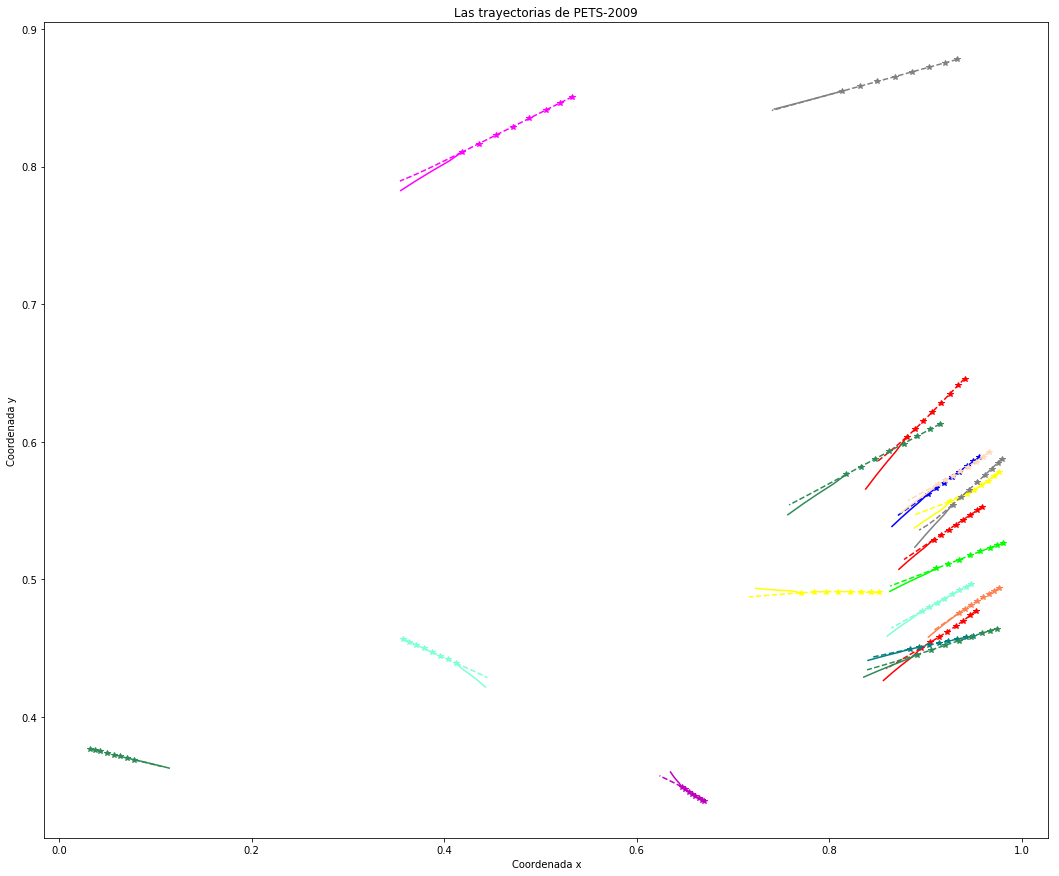

In [40]:
sample_x_persona_pixeles(datos,8,4)

## Analisis cualitativamente

In [ ]:
cruce=[]
cruce.append(datos[3][252:264,:])
cruce.append(datos[4][135:147,:])

paralelos=[]
paralelos.append(datos[2][1:13])
paralelos.append(datos[3][20:32])

inverso=[]
inverso.append(datos[4][167:179])
inverso.append(datos[6][15:27])

In [ ]:
paralelos[0]

In [ ]:
p,v = sample_en_pixeles(inverso,8,4)

In [ ]:
color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]


plot(p[0][0:8,0],p[0][0:8,1],'*--',color= color_names[1],label = 'Observed')
plot(p[0][7:,0],p[0][7:,1],'-',color=color_names[1],label='Predicted')
plot(v[0][7:,0],v[0][7:,1],'--',color=color_names[8],label='Ground truth')

plot(p[1][0:8,0],p[1][0:8,1],'*--',color= color_names[1])
plot(p[1][7:,0],p[1][7:,1],'-',color=color_names[1])
plot(v[1][7:,0],v[1][7:,1],'--',color=color_names[8])

#plt.show()
plt.legend()
plt.savefig("inverso_regre_ing.pdf")
plt.show()